# Prediction intervals

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/etna-team/etna/master?filepath=examples/306-prediction_intervals.ipynb)

This notebook contains overview of prediction intervals functionality in ETNA library.

**Table of contents**

* [Loading and preparing data](#chapter1)
* [Estimating intervals using builtin method](#chapter2)
    * [Accessing prediction intervals in `TSDataset`](#chapter2_1)
    * [Computing interval metrics](#chapter2_2)
* [Estimating prediction intervals using `experimental.prediction_intervals` module](#chapter3)
    * [`NaiveVariancePredictionIntervals`](#chapter3_1)
    * [`ConformalPredictionIntervals`](#chapter3_2)
    * [`EmpiricalPredictionIntervals`](#chapter3_3)
    * [Prediction intervals for ensembles](#chapter3_4)
* [Custom prediction interval method](#chapter4)
    * [Non-parametric method](#chapter4_1)
    * [Estimating historical residuals](#chapter4_2)

In [1]:
import warnings
from copy import deepcopy

import numpy as np
import pandas as pd

from etna.analysis.forecast import plot_forecast
from etna.datasets import TSDataset
from etna.metrics import Coverage
from etna.metrics import Width
from etna.models import CatBoostMultiSegmentModel
from etna.pipeline import Pipeline
from etna.transforms import DateFlagsTransform
from etna.transforms import LagTransform
from etna.transforms import SegmentEncoderTransform

warnings.filterwarnings("ignore")

In [2]:
HORIZON = 30

## Loading and preparing data <a class="anchor" id="chapter1"></a>

Consider the dataset `data/example_dataset.csv`.

This data will be used to show how prediction intervals could be estimated and accessed in ETNA library.

The first step is to load data and convert it to the `TSDataset`.

In [3]:
df = pd.read_csv("data/example_dataset.csv")
df = TSDataset.to_dataset(df=df)
ts = TSDataset(df=df, freq="D")

ts

segment    segment_a segment_b segment_c segment_d
feature       target    target    target    target
timestamp                                         
2019-01-01       170       102        92       238
2019-01-02       243       123       107       358
2019-01-03       267       130       103       366
2019-01-04       287       138       103       385
2019-01-05       279       137       104       384
...              ...       ...       ...       ...
2019-11-26       591       259       196       941
2019-11-27       606       264       196       949
2019-11-28       555       242       207       896
2019-11-29       581       247       186       905
2019-11-30       502       206       169       721

[334 rows x 4 columns]

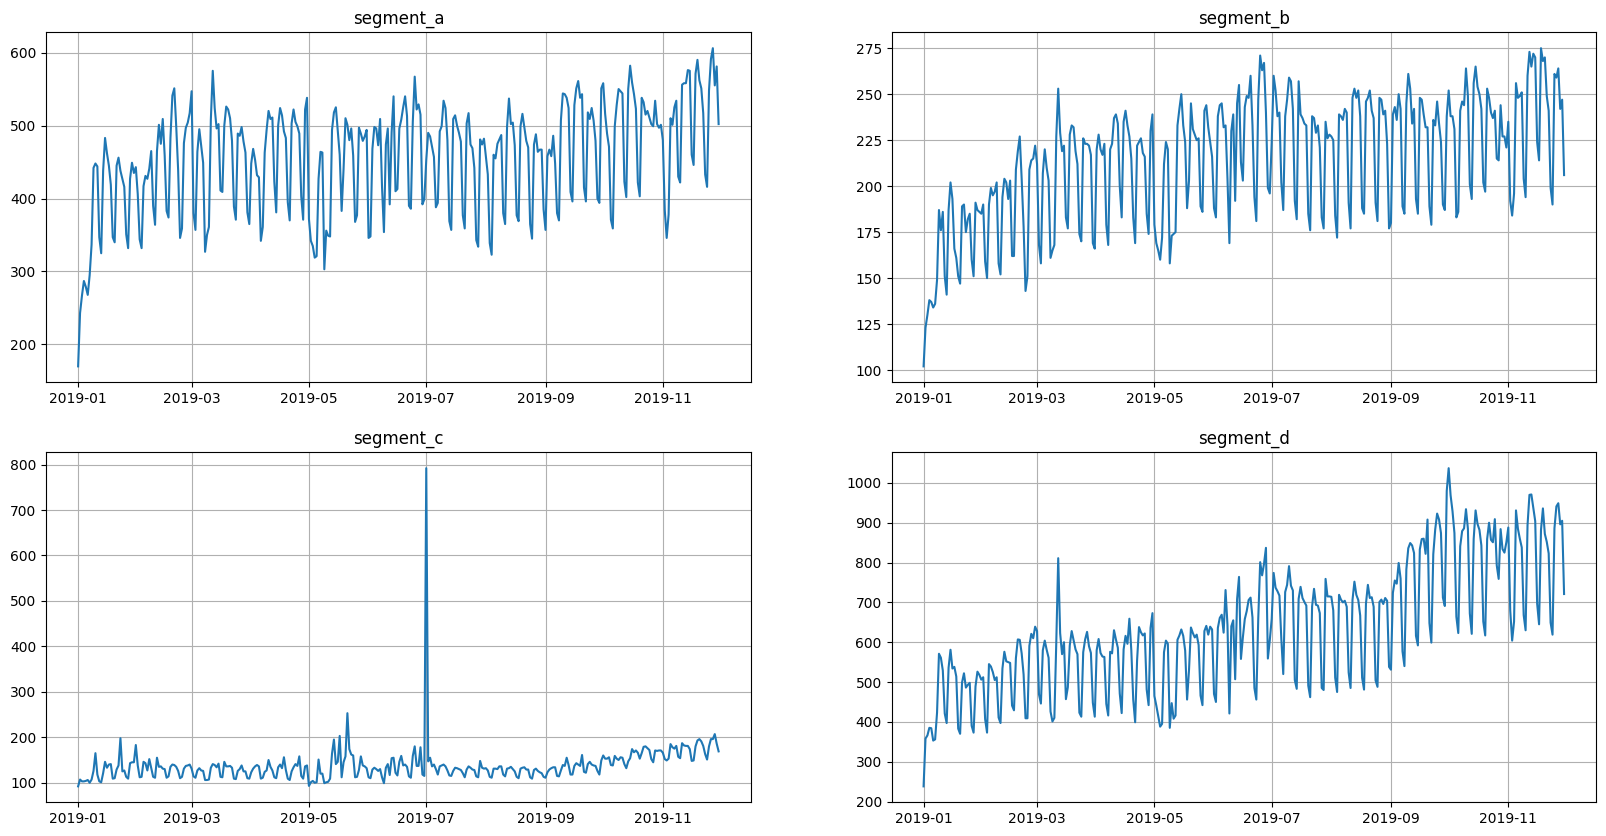

In [4]:
ts.plot()

Here we have four segments in the dataset. All segments have seasonalities, and some of them show signs of trend.
Note that segment C contains an obvious outlier, that may affect quality of estimated intervals.

In the next step, we split our dataset into two parts: train and test. The test part will be used as a hold-out dataset for metrics
computation and result analysis.

In [5]:
train_ts, test_ts = ts.train_test_split(test_size=HORIZON)

## Estimating intervals using builtin method <a class="anchor" id="chapter2"></a>

Currently there are several types of prediction intervals in the library:
1. Quantiles estimates
2. Arbitrary interval borders, that tend to provide desired coverage

Quantiles estimation methods, implemented in the library, use univariate distribution to estimate quantiles at each timestamp in the horizon. There is the possibility of treating all
timestamps in the horizon jointly as multivariate random variable to estimate quantiles, but this approach is not implemented right now. The extension of current method pool will
be discussed in the last section of this notebook.

So there are some naming convention to achieve distinction between two types of intervals. Borders that approximate quantiles named using the following format `{target_{q:.4g}}`, where `q`
is the corresponding quantile level. And there are no particular rules for the arbitrary borders. But it is implementation responsibility to name them appropriately.

Before estimating prediction intervals we need to fit a model. Here `CatBoostMultiSegmentModel` is used with lag and date features.
This model requires computed features, so we add corresponding transforms to the pipeline.

In [6]:
seg = SegmentEncoderTransform()
lags = LagTransform(in_column="target", lags=list(range(HORIZON, 20 + HORIZON)), out_column="lag")
date_flags = DateFlagsTransform(
    day_number_in_week=True,
    day_number_in_month=True,
    week_number_in_month=True,
    week_number_in_year=True,
    month_number_in_year=True,
    year_number=True,
    is_weekend=True,
)

transforms = [lags, date_flags, seg]

In [7]:
model = CatBoostMultiSegmentModel()

In [8]:
pipeline = Pipeline(model=model, transforms=transforms, horizon=HORIZON)

pipeline.fit(ts=train_ts);

After the pipeline is defined and fitted, we are able to estimate prediction intervals with the default method. To do so
set the `prediction_interval=True` parameter of the `forecast` method.

This method is based on residual variance estimation and $z$-scores. Variance estimation is done via running
historical backtest on non-overlapping folds. Number of folds is controlled by the `n_folds` parameter.

In [9]:
forecast = pipeline.forecast(ts=train_ts, prediction_interval=True, n_folds=7)
forecast

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   18.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   26.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   34.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   42.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   48.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   48.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elap

segment                                                                                                                                                                                                                                                                                                                                      segment_a  \
feature    DateFlagsTransform(day_number_in_week = False, day_number_in_month = False, day_number_in_year = False, week_number_in_month = False, week_number_in_year = False, month_number_in_year = False, season_number = False, year_number = False, is_weekend = True, special_days_in_week = (), special_days_in_month = (), out_column = None, )   
timestamp                                                                                                                                                                                                                                                                                                                                                
2019-11-01                                              False                                                                                                                                                                                                                                                                                            
2019-11-02                                               True                                                                                                                                                                                                                                                                                            
2019-11-03                                               True                                                                                                                                                                                                                                                                                            
2019-11-04                                              False                                                                                                                                                                                                                                                                                            
2019-11-05                                              False                                                                                                                                                                                                                                                                                            
2019-11-06                                              False                                                                                                                                                                                                                                                                                            
2019-11-07                                              False                                                                                                                                                                                                                                                                                            
2019-11-08                                              False                                                                                                                                                                                                                                                                                            
2019-11-09                                               True                                                                                                                                     

Here we have a point forecast for the full horizon, along with an estimated prediction interval for each segment.

The section below describes how one can perform manipulations with intervals in the dataset of forecasts.

### Accessing prediction intervals in `TSDataset` <a class="anchor" id="chapter2_1"></a>

Column names for the estimated prediction intervals can be obtained using the `TSDataset.prediction_intervals_names` property.

In [10]:
forecast.prediction_intervals_names

('target_0.025', 'target_0.975')

Here segment names are omitted, because they share interval estimation method. So column names identical for all the segments.

A dataframe with prediction intervals for each segment can be obtained by using the `TSDataset.get_prediction_intervals()` method.

Here, we save such dataframe to a separate object to use later.

In [11]:
prediction_intervals = forecast.get_prediction_intervals()
prediction_intervals

segment       segment_a                 segment_b                 segment_c  \
feature    target_0.025 target_0.975 target_0.025 target_0.975 target_0.025   
timestamp                                                                     
2019-11-01   465.338462   645.705269   172.469985   285.551380    22.954867   
2019-11-02   343.980526   524.347333   128.886375   241.967771    -5.230608   
2019-11-03   330.110008   510.476816   130.716837   243.798232    -7.302589   
2019-11-04   473.699213   654.066021   186.585258   299.666653    23.882084   
2019-11-05   470.415725   650.782532   187.419196   300.500592    21.810229   
2019-11-06   453.593112   633.959920   185.992277   299.073673    23.493258   
2019-11-07   459.223105   639.589913   190.098041   303.179437    24.301886   
2019-11-08   460.635617   641.002425   174.545771   287.627166    25.824648   
2019-11-09   352.237355   532.604163   135.017463   248.098859     2.284398   
2019-11-10   340.566504   520.933312   134.317424   247.398820    -4.175281   
2019-11-11   481.614673   661.981481   192.064536   305.145932    30.899955   
2019-11-12   485.982837   666.349645   191.706150   304.787546    38.543446   
2019-11-13   468.583873   648.950680   188.980254   302.061650    37.050253   
2019-11-14   479.819978   660.186786   192.571987   305.653382    30.738932   
2019-11-15   481.407357   661.774165   183.850686   296.932081    40.043141   
2019-11-16   354.518573   534.885381   135.722830   248.804226     2.772774   
2019-11-17   361.677902   542.044710   142.588435   255.669831    10.796242   
2019-11-18   487.671981   668.038789   188.434795   301.516191    43.035218   
2019-11-19   494.135768   674.502576   193.605644   306.687040    43.318375   
2019-11-20   476.315090   656.681898   195.592255   308.673651    41.469468   
2019-11-21   472.249261   652.616068   192.592784   305.674180    52.739038   
2019-11-22   453.171683   633.538491   190.082047   303.163442    41.505652   
2019-11-23   352.798082   533.164890   146.806995   259.888390    15.843691   
2019-11-24   346.889985   527.256793   143.884093   256.965488    23.831318   
2019-11-25   492.158918   672.525726   202.239985   315.321380    61.309479   
2019-11-26   495.540553   675.907361   198.729919   311.811315    63.097782   
2019-11-27   481.361832   661.728640   213.071026   326.152421    78.719570   
2019-11-28   493.015803   673.382611   204.943828   318.025224    70.263982   
2019-11-29   473.727818   654.094626   190.872182   303.953577    55.667550   
2019-11-30   382.195359   562.562167   138.237995   251.319391    25.485112   

segment                    segment_d               
feature    target_0.975 target_0.025 target_0.975  
timestamp                                          
2019-11-01   267.313430   750.444933  1054.133854  
2019-11-02   239.127954   621.751448   925.440368  
2019-11-03   237.055973   600.721487   904.410408  
2019-11-04   268.240647   753.859842  1057.548763  
2019-11-05   266.168792   721.781165  1025.470086  
2019-11-06   267.851821   705.522443  1009.211363  
2019-11-07   268.660449   727.924724  1031.613644  
2019-11-08   270.183210   750.318659  1054.007580  
2019-11-09   246.642961   647.075203   950.764124  
2019-11-10   240.183281   627.678521   931.367442  
2019-11-11   275.258518   745.986465  1049.675386  
2019-11-12   282.902009   737.615895  1041.304816  
2019-11-13   281.408815   712.617748  1016.306669  
2019-11-14   275.097495   725.194461  1028.883382  
2019-11-15   284.401704   756.294007  1059.982928  
2019-11-16   247.131337   640.556552   944.245473  
2019-11-17   255.154805   625.242912   928.931833  
2019-11-18   287.393781   747.885757  1051.574678  
2019-11-19   287.676938   721.336853  1025.025774  
2019-11-20   285.828031   704.456374  1008.145295  
2019-11-21   297.097601   728.848615  1032.537536  
2019-11-22   285.864215   758.578081  1062.267002  
2019-11-23   260.202254   618.146421   921.835341  
2019-11-24   268.189881   597.399816   9

If estimated intervals are no longer needed or there is a necessity to remove prediction intervals from the dataset use
`TSDataset.drop_prediction_intervals()` method.

Once we removed intervals, we can check that they are no longer presented by looking at stored names.

In [12]:
forecast.drop_prediction_intervals()
forecast.prediction_intervals_names

()

Here we see that property contains an empty tuple now. It is an indication that no intervals are registered.

In [13]:
forecast.get_prediction_intervals()

Calling `TSDataset.get_prediction_intervals()` in such a case will return `None`.

There is a possibility of adding existing prediction intervals to the dataset. To do so, one should use
`TSDataset.add_prediction_intervals()` method.

There are a couple requirements when adding existing intervals to the dataset.
1. There are should be no intervals in the dataset. This could be checked via the `prediction_intervals_names` property.
2. The dataframe with intervals should be in ETNA wide format.
3. All segments should be matched between the dataset and intervals dataframe.
4. Interval border sets should match for all the segments.

In [14]:
forecast.add_prediction_intervals(prediction_intervals_df=prediction_intervals)
forecast.prediction_intervals_names

('target_0.025', 'target_0.975')

In [15]:
forecast

segment                                                                                                                                                                                                                                                                                                                                      segment_a  \
feature    DateFlagsTransform(day_number_in_week = False, day_number_in_month = False, day_number_in_year = False, week_number_in_month = False, week_number_in_year = False, month_number_in_year = False, season_number = False, year_number = False, is_weekend = True, special_days_in_week = (), special_days_in_month = (), out_column = None, )   
timestamp                                                                                                                                                                                                                                                                                                                                                
2019-11-01                                              False                                                                                                                                                                                                                                                                                            
2019-11-02                                               True                                                                                                                                                                                                                                                                                            
2019-11-03                                               True                                                                                                                                                                                                                                                                                            
2019-11-04                                              False                                                                                                                                                                                                                                                                                            
2019-11-05                                              False                                                                                                                                                                                                                                                                                            
2019-11-06                                              False                                                                                                                                                                                                                                                                                            
2019-11-07                                              False                                                                                                                                                                                                                                                                                            
2019-11-08                                              False                                                                                                                                                                                                                                                                                            
2019-11-09                                               True                                                                                                                                     

We called `prediction_intervals_names` here to ensure that intervals were correctly added and printed out the resulting dataset.

Results visualization could be done using the `plot_forecast` function. Setting parameter `prediction_intervals=True` will
enable plotting estimated prediction intervals.

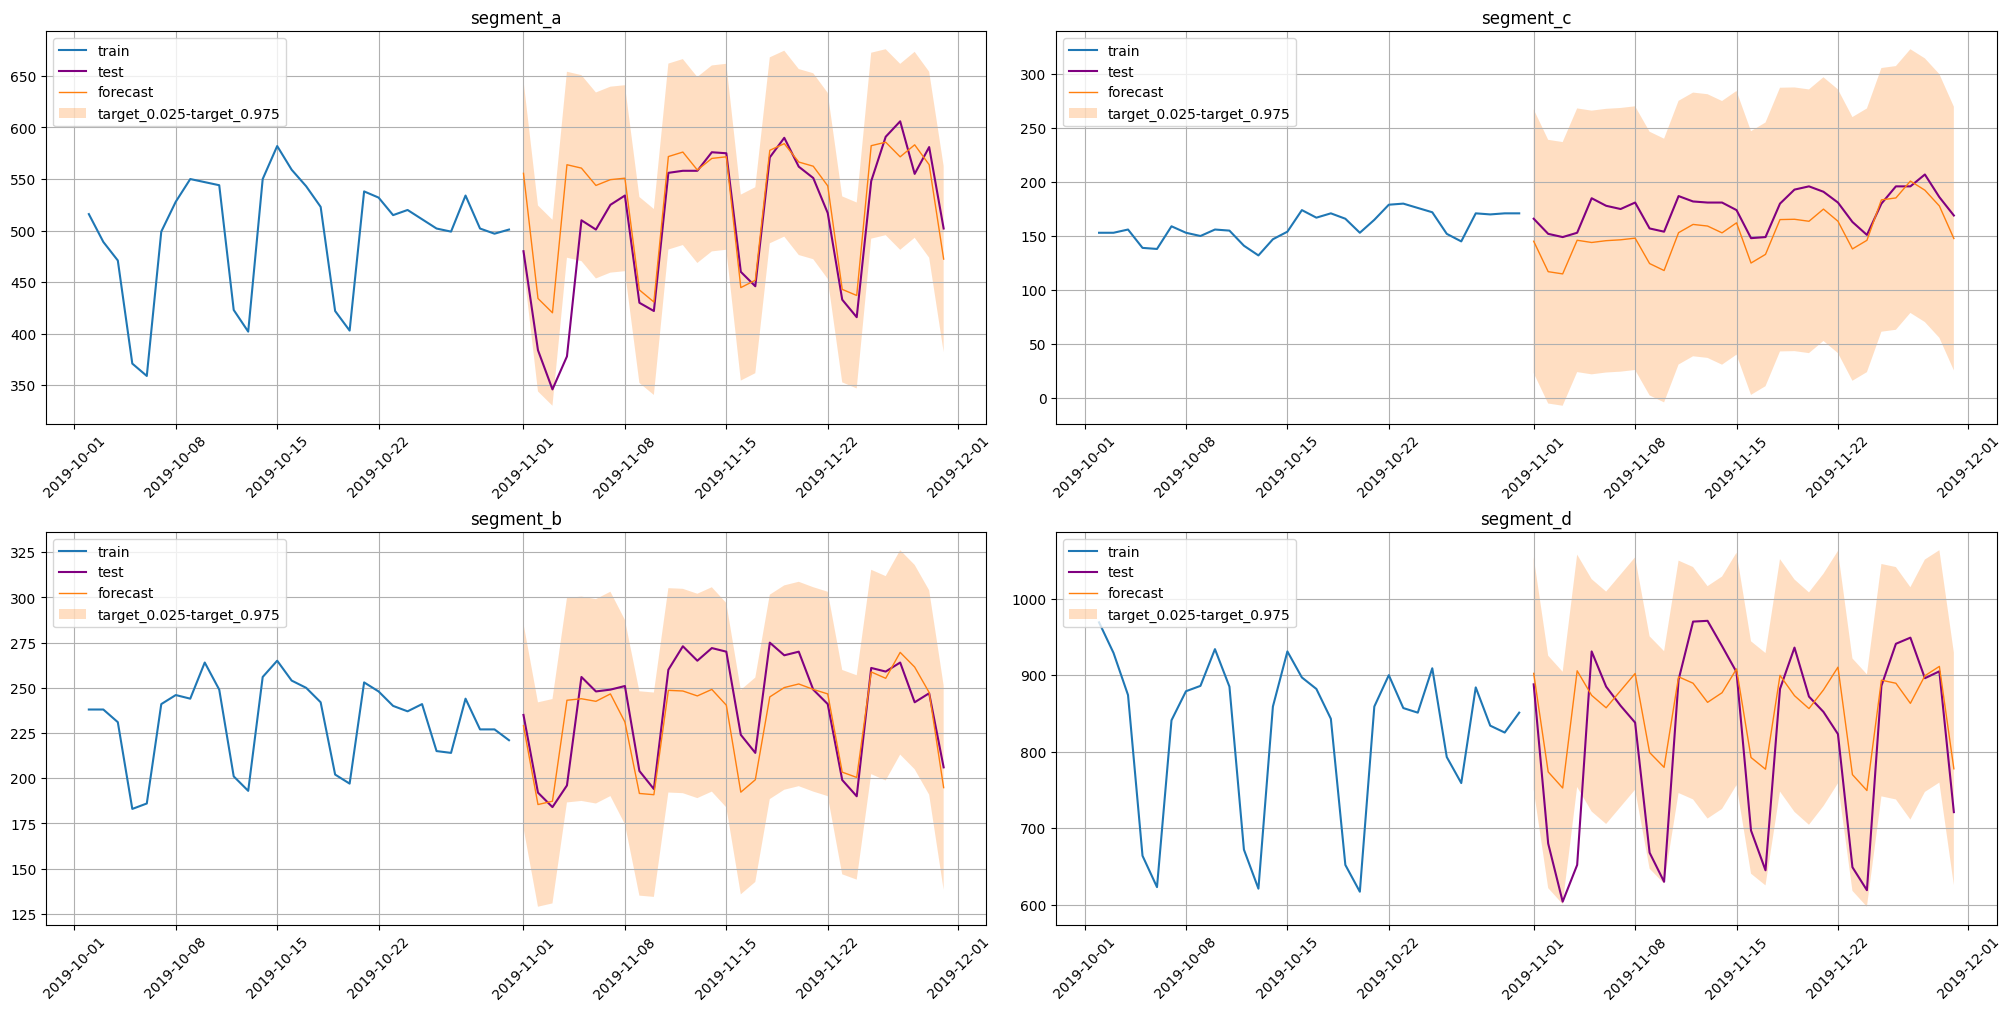

In [16]:
plot_forecast(forecast, test_ts, train_ts, prediction_intervals=True, n_train_samples=30)

### Computing interval metrics <a class="anchor" id="chapter2_2"></a>

There are a couple of metrics in the library that can help estimate the quality of computed prediction intervals:
* `Coverage` - percentage of points in the horizon that fall between interval borders
* `Width` - mean distance between intervals borders at each timestamp of the horizon.

These metrics require initialization. To specify which interval to use provide border names by setting
`lower_name` and `upper_name` parameters. After initialization these metrics will try to find specified borders in
the dataset with predicted values. If provided names are not found, a corresponding error will be raised.

If estimated intervals borders are quantiles desired levels could be selected by setting the `quantiles` parameter. Usage of both ways of interval selection will lead to an error.

Here we wrap metrics estimation in one function.

In [17]:
def interval_metrics(test_ts, forecast):
    lower_name, upper_name = forecast.prediction_intervals_names

    coverage = Coverage(lower_name=lower_name, upper_name=upper_name)(test_ts, forecast)
    width = Width(lower_name=lower_name, upper_name=upper_name)(test_ts, forecast)

    return coverage, width

In [18]:
coverage, width = interval_metrics(test_ts=test_ts, forecast=forecast)

In [19]:
coverage

{'segment_a': 0.9666666666666667,
 'segment_b': 1.0,
 'segment_c': 1.0,
 'segment_d': 0.9666666666666667}

In [20]:
width

{'segment_a': 180.3668077488267,
 'segment_b': 113.08139547303111,
 'segment_c': 244.35856287627038,
 'segment_d': 303.6889207235126}

## Estimating prediction intervals using `experimental.prediction_intervals` module <a class="anchor" id="chapter3"></a>

The ETNA library provides several alternative methods for prediction interval estimation. All necessary functionality is
in the `etna.experimental.prediction_intervals` module.

This section covers currently implemented methods. Also, the module provides the possibility to easily extend the method list by implementing a custom one.
This topic will be discussed in the last section.

Prediction interval functionality is implemented via wrapper classes for the ETNA pipelines. During initialization,
such methods require pipeline instances and necessary hyperparameters. Provided pipeline can be fitted before or after wrapping with the interval estimation method.

### `NaiveVariancePredictionIntervals` <a class="anchor" id="chapter3_1"></a>

This method estimate prediction quantiles using the following algorithm:

1. Compute the residuals matrix $r_{it} = \hat y_{it} - y_{it}$ using k-fold backtest, where $i$ is fold index.

2. Estimate variance for each step in the prediction horizon $v_t = \frac{1}{k} \sum_{i = 1}^k r_{it}^2$.

3. Use $z$-scores and estimated variance to compute corresponding quantiles.


Desired quantiles levels for the prediction interval can be set via `quantiles` of the `forecast` method.

In [21]:
from etna.experimental.prediction_intervals import NaiveVariancePredictionIntervals

pipeline = NaiveVariancePredictionIntervals(pipeline=pipeline)

forecast = pipeline.forecast(quantiles=(0.025, 0.975), prediction_interval=True, n_folds=40)

forecast

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   15.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   21.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   26.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   31.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   38.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   44.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   50.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   56.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  3.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBac

segment                                                                                                                                                                                                                                                                                                                                      segment_a  \
feature    DateFlagsTransform(day_number_in_week = False, day_number_in_month = False, day_number_in_year = False, week_number_in_month = False, week_number_in_year = False, month_number_in_year = False, season_number = False, year_number = False, is_weekend = True, special_days_in_week = (), special_days_in_month = (), out_column = None, )   
timestamp                                                                                                                                                                                                                                                                                                                                                
2019-11-01                                              False                                                                                                                                                                                                                                                                                            
2019-11-02                                               True                                                                                                                                                                                                                                                                                            
2019-11-03                                               True                                                                                                                                                                                                                                                                                            
2019-11-04                                              False                                                                                                                                                                                                                                                                                            
2019-11-05                                              False                                                                                                                                                                                                                                                                                            
2019-11-06                                              False                                                                                                                                                                                                                                                                                            
2019-11-07                                              False                                                                                                                                                                                                                                                                                            
2019-11-08                                              False                                                                                                                                                                                                                                                                                            
2019-11-09                                               True                                                                                                                                     

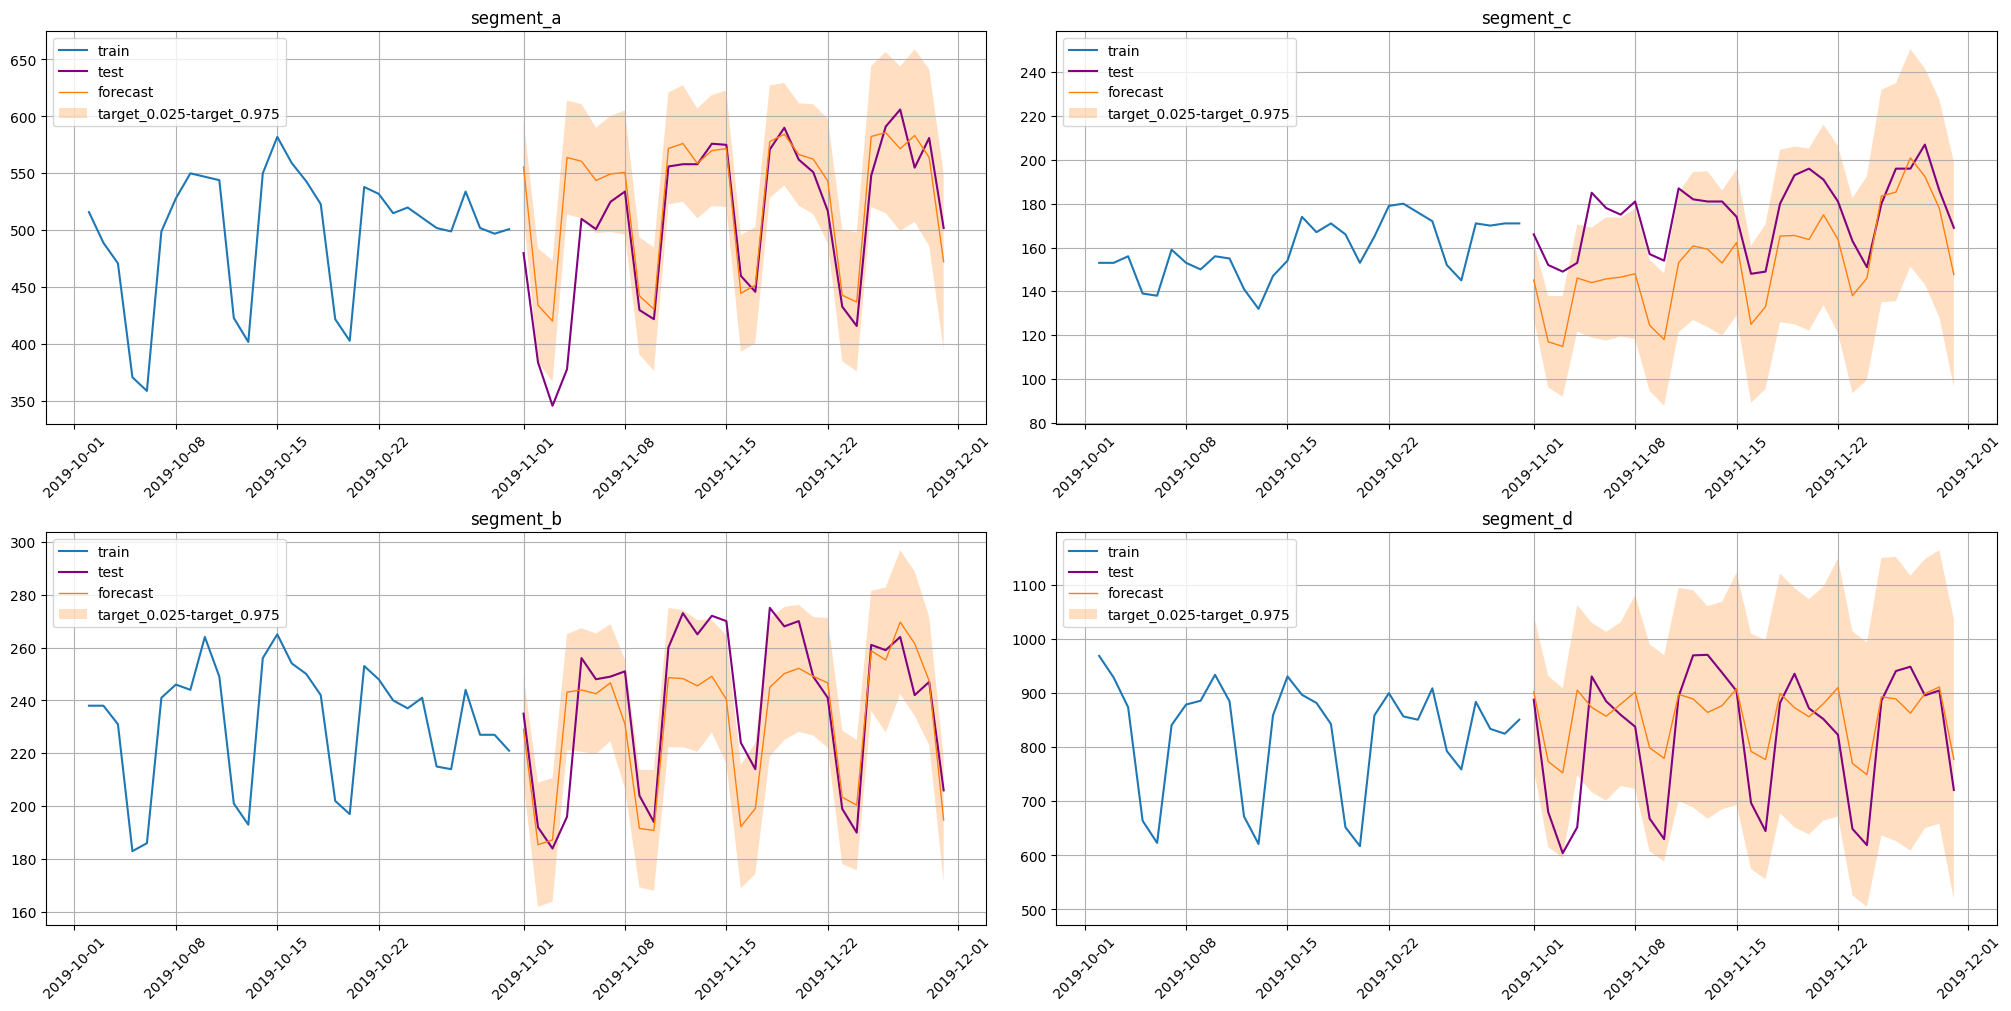

In [22]:
plot_forecast(forecast, test_ts, train_ts, prediction_intervals=True, n_train_samples=30)

In [23]:
coverage, width = interval_metrics(test_ts=test_ts, forecast=forecast)

In [24]:
coverage

{'segment_a': 0.8333333333333334,
 'segment_b': 0.8333333333333334,
 'segment_c': 0.6666666666666666,
 'segment_d': 0.9666666666666667}

In [25]:
width

{'segment_a': 109.87110044753541,
 'segment_b': 48.16577720497198,
 'segment_c': 72.76443300963885,
 'segment_d': 414.72206380862985}

### `ConformalPredictionIntervals` <a class="anchor" id="chapter3_2"></a>

Estimates conformal prediction intervals:

1. Compute matrix of absolute residuals  $r_{it} = |\hat y_{it} - y_{it}|$ using k-fold historical backtest, where $i$ is fold index.

2. Estimate corresponding quantiles levels using the provided coverage (e.g. apply Bonferroni correction).

3. Estimate quantiles for each horizon step separately using computed absolute residuals and levels.


**Note**: this method estimates arbitrary interval bounds that tend to provide a given coverage rate.
So this method ignores the `quantiles` parameter of the `forecast` method.

Coverage rate and correction option should be set at the method initialization step.

In [26]:
from etna.experimental.prediction_intervals import ConformalPredictionIntervals

pipeline = ConformalPredictionIntervals(pipeline=pipeline, coverage=0.95, bonferroni_correction=True)

forecast = pipeline.forecast(prediction_interval=True, n_folds=40)

forecast

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   15.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   20.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   26.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   31.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   37.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   44.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   49.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   54.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  3.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBac

segment                                                                                                                                                                                                                                                                                                                                      segment_a  \
feature    DateFlagsTransform(day_number_in_week = False, day_number_in_month = False, day_number_in_year = False, week_number_in_month = False, week_number_in_year = False, month_number_in_year = False, season_number = False, year_number = False, is_weekend = True, special_days_in_week = (), special_days_in_month = (), out_column = None, )   
timestamp                                                                                                                                                                                                                                                                                                                                                
2019-11-01                                              False                                                                                                                                                                                                                                                                                            
2019-11-02                                               True                                                                                                                                                                                                                                                                                            
2019-11-03                                               True                                                                                                                                                                                                                                                                                            
2019-11-04                                              False                                                                                                                                                                                                                                                                                            
2019-11-05                                              False                                                                                                                                                                                                                                                                                            
2019-11-06                                              False                                                                                                                                                                                                                                                                                            
2019-11-07                                              False                                                                                                                                                                                                                                                                                            
2019-11-08                                              False                                                                                                                                                                                                                                                                                            
2019-11-09                                               True                                                                                                                                     

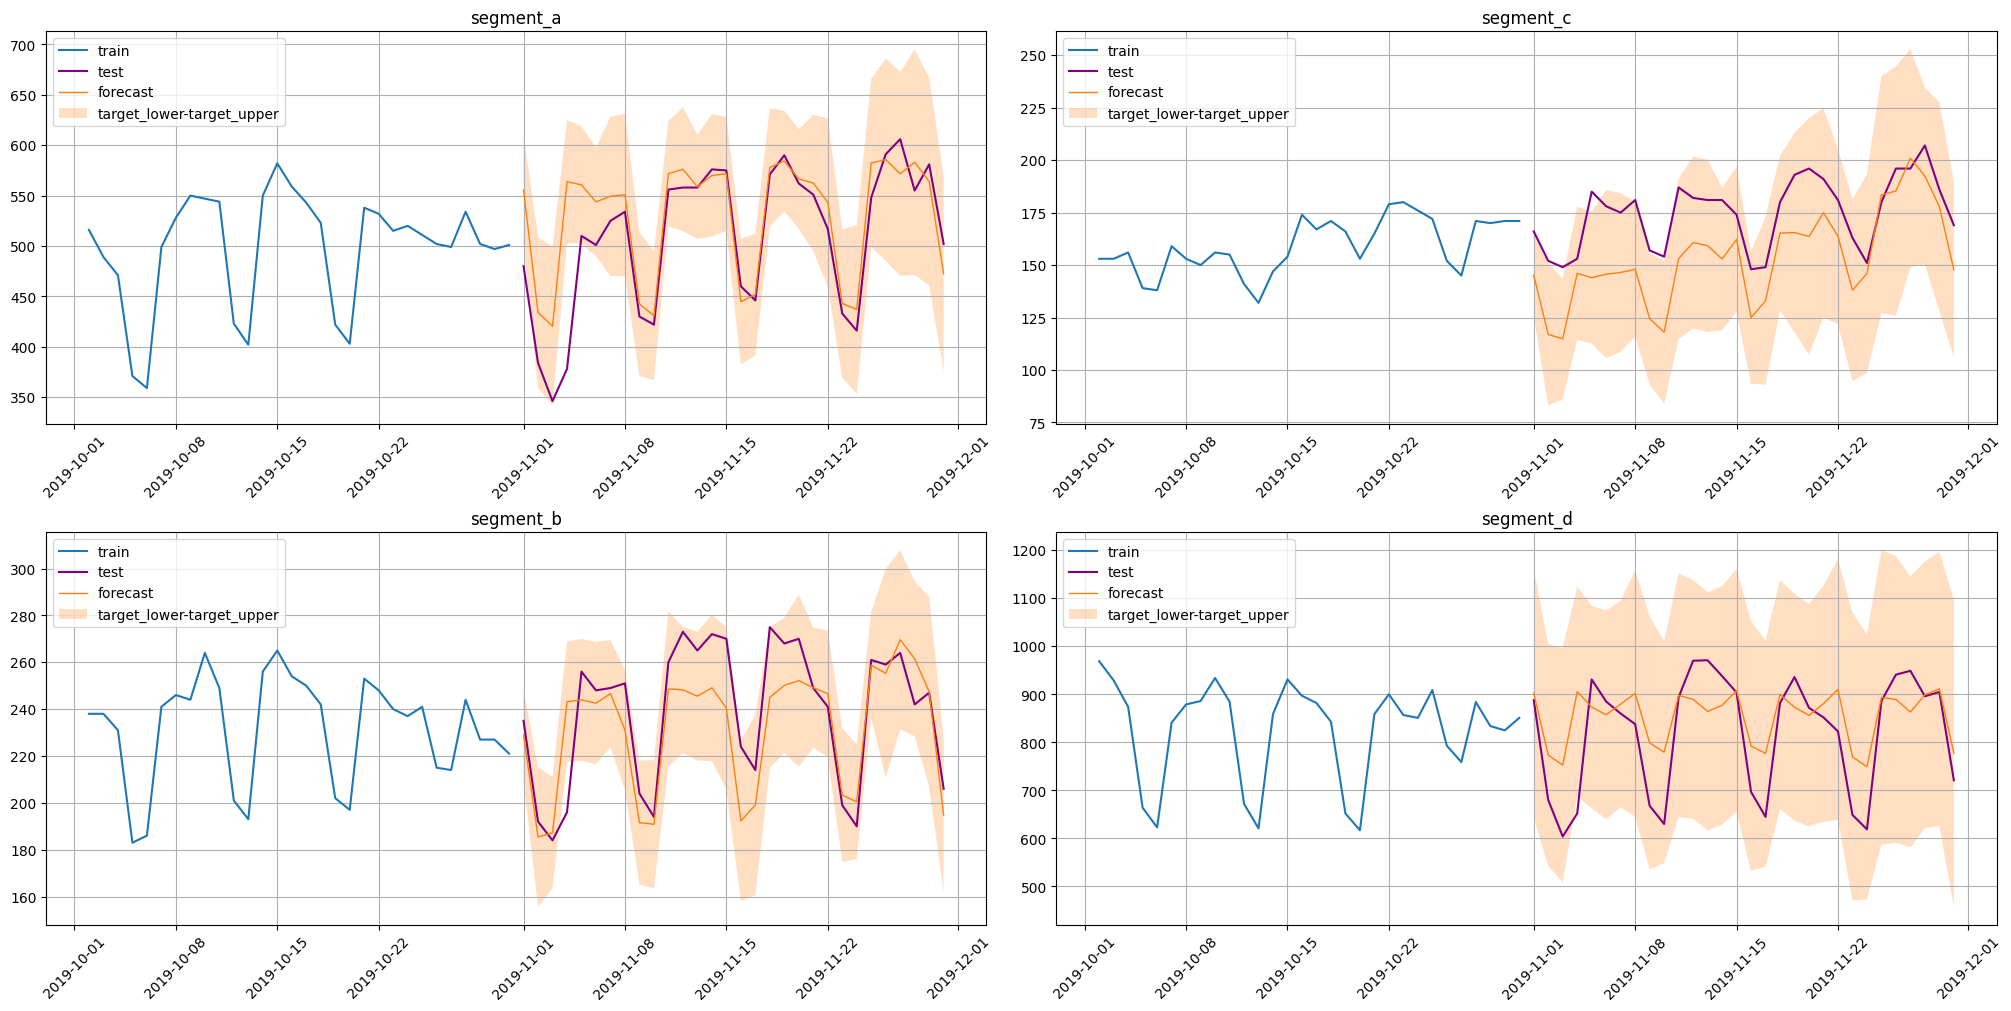

In [27]:
plot_forecast(forecast, test_ts, train_ts, prediction_intervals=True, n_train_samples=30)

In [28]:
coverage, width = interval_metrics(test_ts=test_ts, forecast=forecast)

In [29]:
coverage

{'segment_a': 0.9333333333333333,
 'segment_b': 0.9666666666666667,
 'segment_c': 0.7666666666666667,
 'segment_d': 0.9666666666666667}

In [30]:
width

{'segment_a': 143.0645884940778,
 'segment_b': 59.482822263351,
 'segment_c': 80.39547754516973,
 'segment_d': 510.838139056879}

### `EmpiricalPredictionIntervals` <a class="anchor" id="chapter3_3"></a>

Estimates prediction intervals via historical residuals:

1. Compute matrix of residuals $r_{it} = |\hat y_{it} - y_{it}|$ using k-fold backtest, where $i$ is fold index.

2. Estimate quantiles levels, that satisfy the provided coverage, for the corresponding residuals distributions.

3. Estimate quantiles for each timestamp using computed residuals and levels.


**Note**: this method estimates arbitrary interval bounds that tend to provide a given coverage rate.
So this method ignores the `quantiles` parameter of the `forecast` method.

Coverage rate and correction option should be set at method initialization step.

In [31]:
from etna.experimental.prediction_intervals import EmpiricalPredictionIntervals

pipeline = EmpiricalPredictionIntervals(pipeline=pipeline)

forecast = pipeline.forecast(prediction_interval=True, n_folds=40)

forecast

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   15.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   20.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   25.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   31.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   36.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   41.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   46.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   51.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  3.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBac

segment                                                                                                                                                                                                                                                                                                                                      segment_a  \
feature    DateFlagsTransform(day_number_in_week = False, day_number_in_month = False, day_number_in_year = False, week_number_in_month = False, week_number_in_year = False, month_number_in_year = False, season_number = False, year_number = False, is_weekend = True, special_days_in_week = (), special_days_in_month = (), out_column = None, )   
timestamp                                                                                                                                                                                                                                                                                                                                                
2019-11-01                                              False                                                                                                                                                                                                                                                                                            
2019-11-02                                               True                                                                                                                                                                                                                                                                                            
2019-11-03                                               True                                                                                                                                                                                                                                                                                            
2019-11-04                                              False                                                                                                                                                                                                                                                                                            
2019-11-05                                              False                                                                                                                                                                                                                                                                                            
2019-11-06                                              False                                                                                                                                                                                                                                                                                            
2019-11-07                                              False                                                                                                                                                                                                                                                                                            
2019-11-08                                              False                                                                                                                                                                                                                                                                                            
2019-11-09                                               True                                                                                                                                     

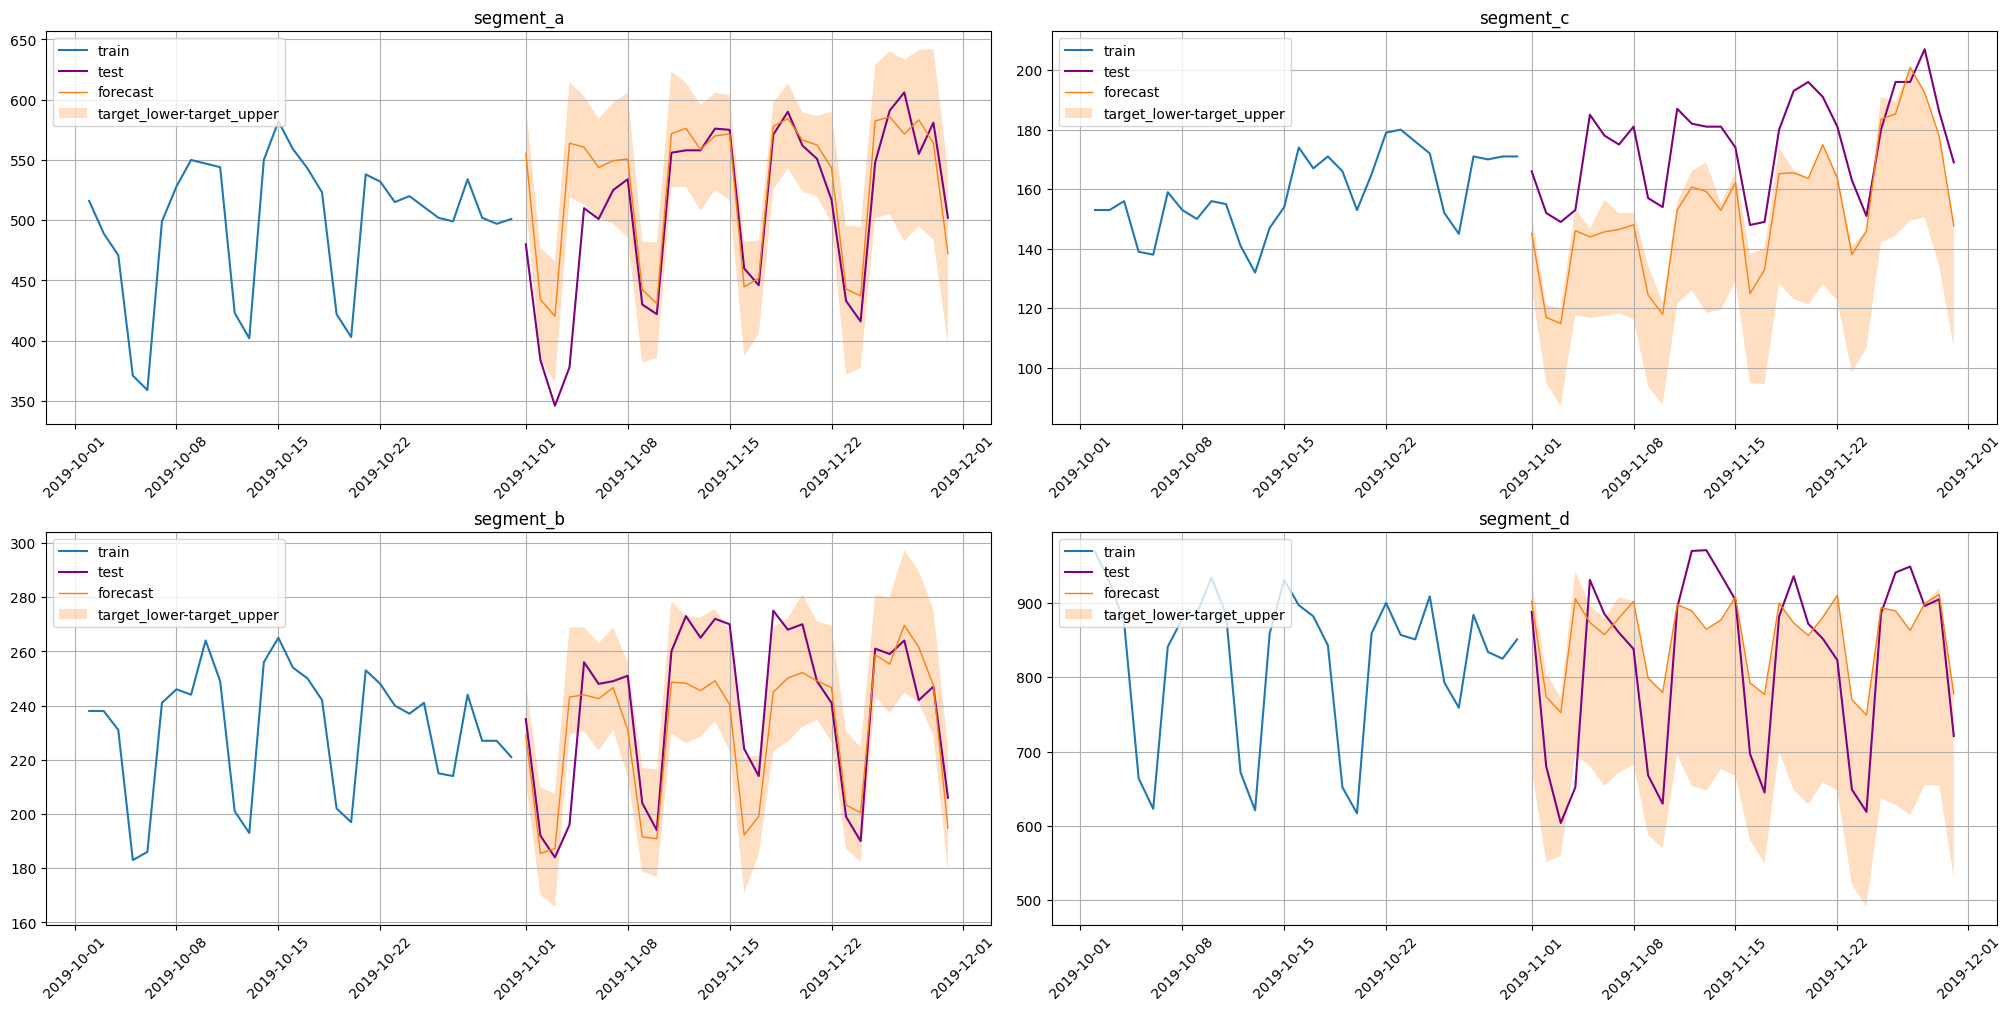

In [32]:
plot_forecast(forecast, test_ts, train_ts, prediction_intervals=True, n_train_samples=30)

In [33]:
coverage, width = interval_metrics(test_ts=test_ts, forecast=forecast)

In [34]:
coverage

{'segment_a': 0.8,
 'segment_b': 0.8666666666666667,
 'segment_c': 0.1,
 'segment_d': 0.6666666666666666}

In [35]:
width

{'segment_a': 101.35860922729344,
 'segment_b': 42.78417545687474,
 'segment_c': 39.840027109366886,
 'segment_d': 232.83680438643344}

### Prediction intervals for ensembles <a class="anchor" id="chapter3_4"></a>

Pipeline ensembles could be passed to interval methods as well.

Consider a short usage example with `VotingEnsemble`.

In [36]:
from etna.ensembles import VotingEnsemble

ensemble = VotingEnsemble(pipelines=[deepcopy(pipeline), deepcopy(pipeline)])
ensemble = NaiveVariancePredictionIntervals(pipeline=ensemble, stride=HORIZON)

forecast = pipeline.forecast(prediction_interval=True, n_folds=5)

forecast.prediction_intervals_names

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   17.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   22.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   27.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   27.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elap

('target_lower', 'target_upper')

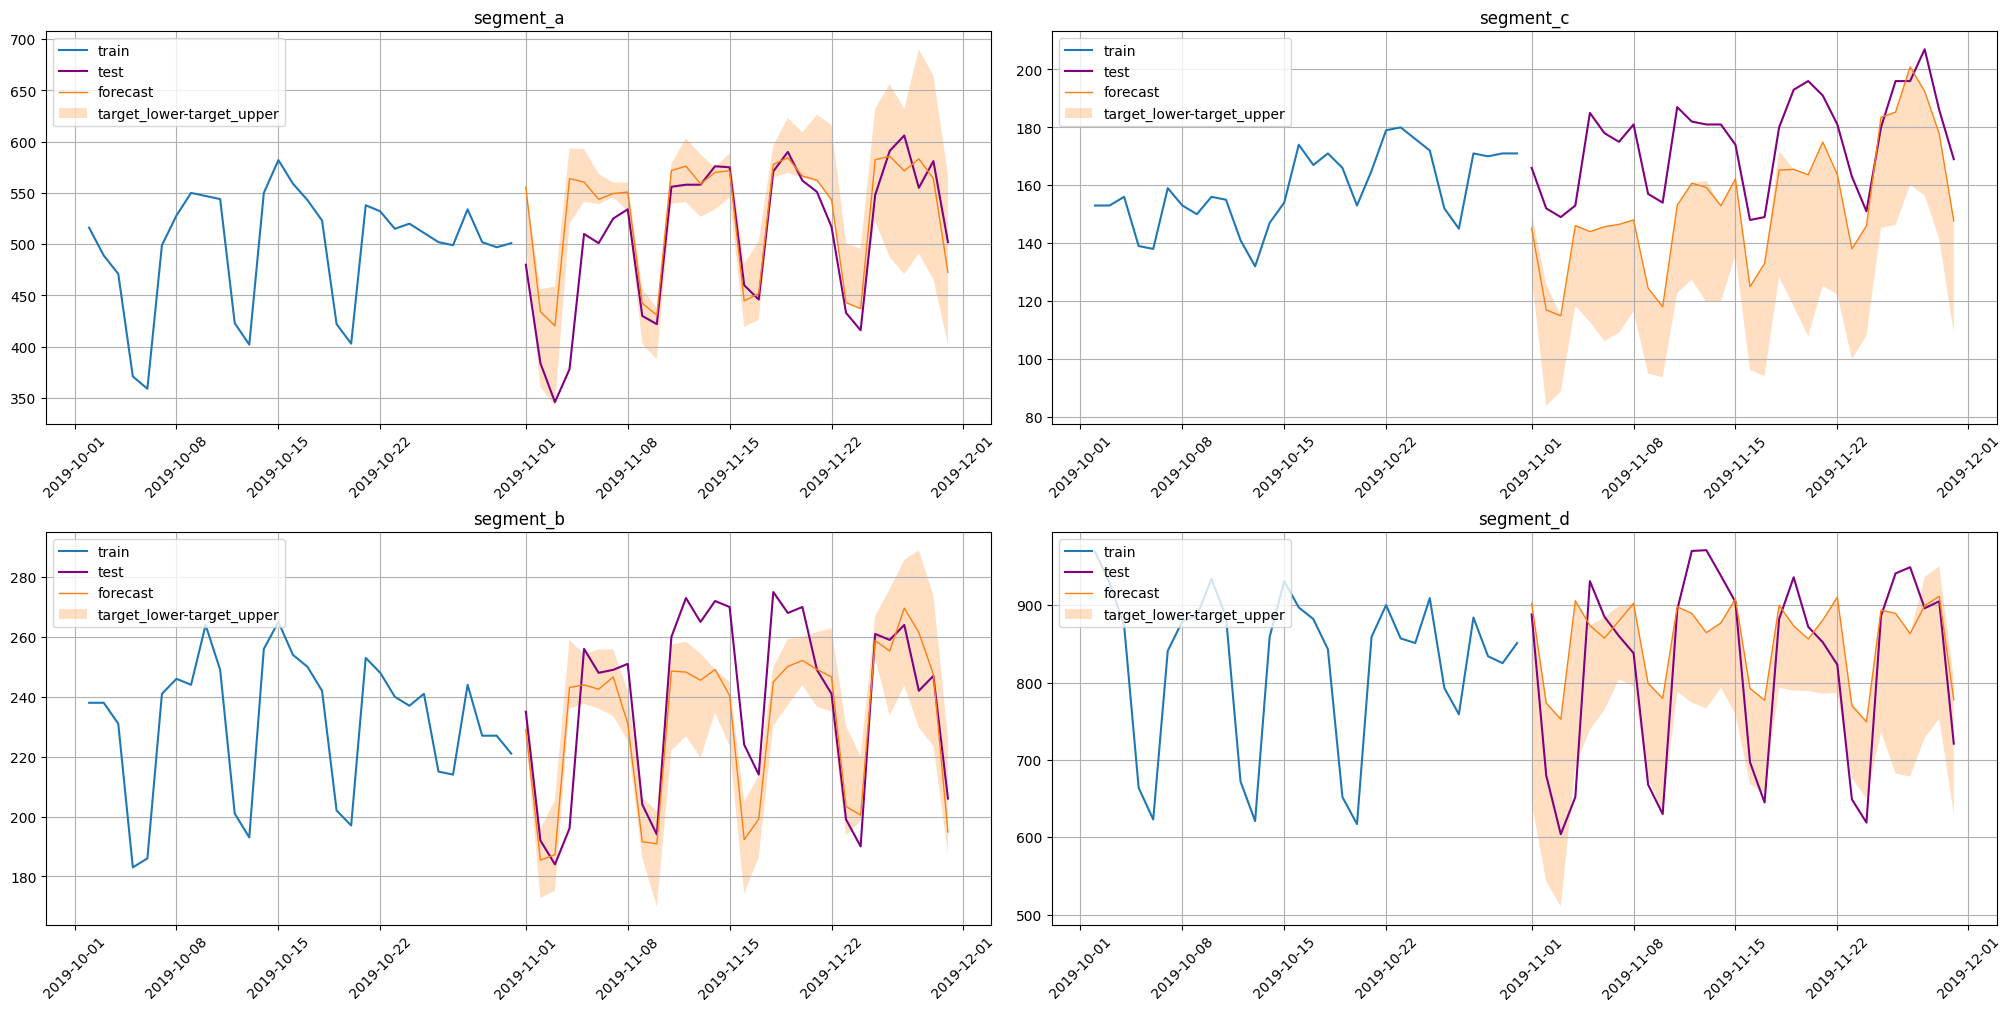

In [37]:
plot_forecast(forecast, test_ts, train_ts, prediction_intervals=True, n_train_samples=30)

## Custom prediction interval method <a class="anchor" id="chapter4"></a>

There is a possibility in the library to extend the set of prediction intervals methods by implementing the desired algorithm.
This section demonstrates how it can be done. Examples of interface and utilities usage are provided as well.

`BasePredictionIntervals` - base class for prediction intervals methods.

This class implements a wrapper interface for pipelines and ensembles that provides the ability to estimate prediction intervals.
So it requires a pipeline instance to be provided to the `__init__` method for proper initialization.

To add a particular method for pipelines, one must inherit from this class and provide an implementation for
the abstract method ``_forecast_prediction_interval``. This method should estimate and store prediction intervals for out-of-sample forecasts.

**Limitations**
In-sample prediction is not supported by default and will raise a corresponding error while attempting to do so.
This functionality could be implemented if needed by overriding the ``_predict`` method, which is responsible for building
an in-sample point forecast and adding prediction intervals.

### Non-parametric method <a class="anchor" id="chapter4_1"></a>

The example below demonstrates how the interval method could be implemented.

Consider 'ConstantWidthInterval', which simply adds constant `width` to a point forecast. Here `width` is a hyperparameter that
will be set on the method initialization step.

In [38]:
from typing import Sequence

from etna.experimental.prediction_intervals import BasePredictionIntervals
from etna.pipeline import BasePipeline

In [39]:
class ConstantWidthInterval(BasePredictionIntervals):
    def __init__(self, pipeline: BasePipeline, interval_width: float):
        assert interval_width > 0

        self.interval_width = interval_width
        super().__init__(pipeline=pipeline)

    def _forecast_prediction_interval(
        self, ts: TSDataset, predictions: TSDataset, quantiles: Sequence[float], n_folds: int
    ) -> TSDataset:
        predicted_target = predictions[..., "target"]

        lower_border = predicted_target - self.interval_width / 2
        upper_border = predicted_target + self.interval_width / 2

        upper_border.rename({"target": "target_upper"}, inplace=True, axis=1)
        lower_border.rename({"target": "target_lower"}, inplace=True, axis=1)

        predictions.add_prediction_intervals(prediction_intervals_df=pd.concat([lower_border, upper_border], axis=1))
        return predictions

In [40]:
pipeline = ConstantWidthInterval(pipeline=pipeline, interval_width=150)

forecast = pipeline.forecast(prediction_interval=True, n_folds=40)

forecast

segment                                                                                                                                                                                                                                                                                                                                      segment_a  \
feature    DateFlagsTransform(day_number_in_week = False, day_number_in_month = False, day_number_in_year = False, week_number_in_month = False, week_number_in_year = False, month_number_in_year = False, season_number = False, year_number = False, is_weekend = True, special_days_in_week = (), special_days_in_month = (), out_column = None, )   
timestamp                                                                                                                                                                                                                                                                                                                                                
2019-11-01                                              False                                                                                                                                                                                                                                                                                            
2019-11-02                                               True                                                                                                                                                                                                                                                                                            
2019-11-03                                               True                                                                                                                                                                                                                                                                                            
2019-11-04                                              False                                                                                                                                                                                                                                                                                            
2019-11-05                                              False                                                                                                                                                                                                                                                                                            
2019-11-06                                              False                                                                                                                                                                                                                                                                                            
2019-11-07                                              False                                                                                                                                                                                                                                                                                            
2019-11-08                                              False                                                                                                                                                                                                                                                                                            
2019-11-09                                               True                                                                                                                                     

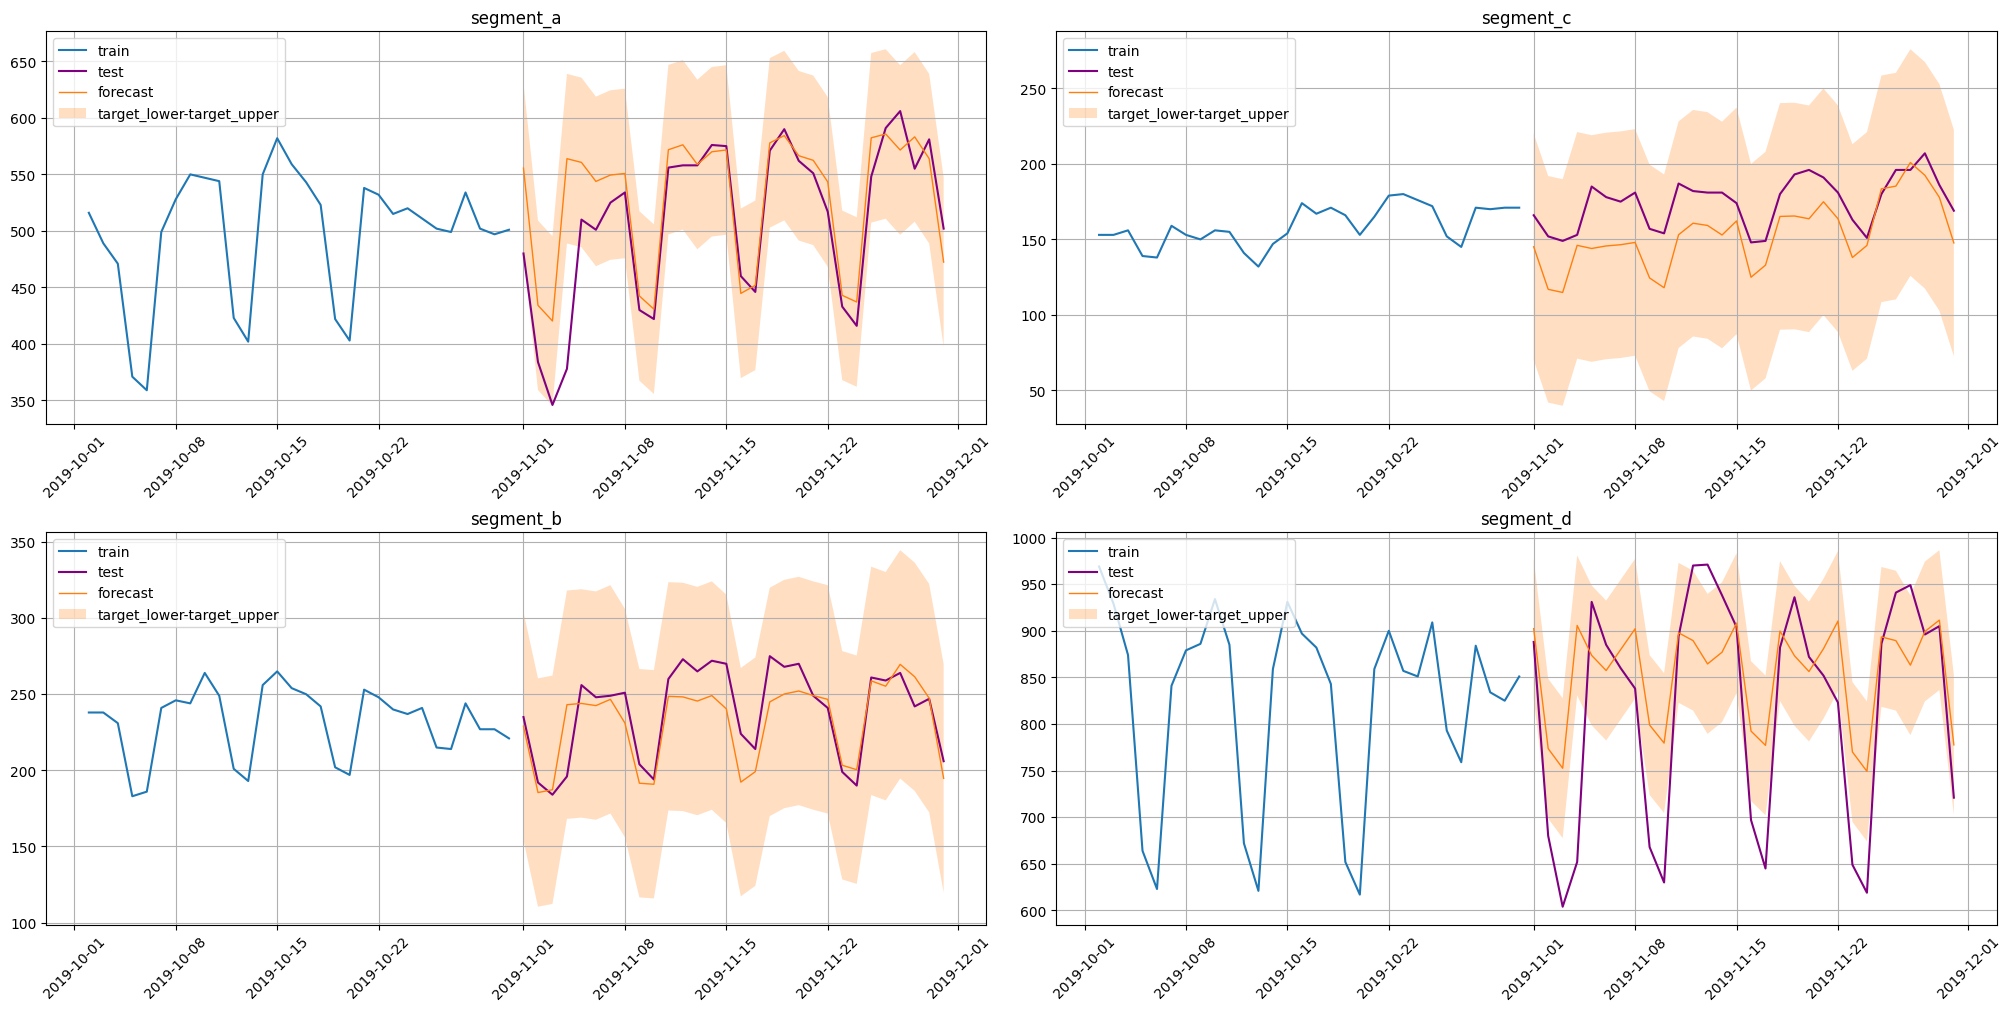

In [41]:
plot_forecast(forecast, test_ts, train_ts, prediction_intervals=True, n_train_samples=30)

In [42]:
coverage, width = interval_metrics(test_ts=test_ts, forecast=forecast)

In [43]:
coverage

{'segment_a': 0.9333333333333333,
 'segment_b': 1.0,
 'segment_c': 1.0,
 'segment_d': 0.5666666666666667}

In [44]:
width

{'segment_a': 150.0,
 'segment_b': 150.0,
 'segment_c': 150.0,
 'segment_d': 150.0}

### Estimating historical residuals <a class="anchor" id="chapter4_2"></a>

Some prediction intervals methods require doing historical forecasts. This could be done by using the pipeline's `get_historical_forecasts` method.
As `BasePredictionIntervals` wraps pipelines, this method is implemented here as well.

Consider the example `MaxAbsResidInterval`. This method estimates intervals based on the maximum
absolute values of historical residuals for each segment. So we can break down this algorithm into the following steps:

1. Estimate historical forecasts by calling the `get_historical_forecasts` method.
2. For each `segment` estimate residuals, find the maximum absolute value and add to the point forecast.

In [45]:
class MaxAbsResidInterval(BasePredictionIntervals):
    def __init__(self, pipeline: BasePipeline, coverage: float = 0.95, stride: int = 1):
        assert stride > 0
        assert 0 < coverage <= 1

        self.stride = stride
        self.coverage = coverage
        super().__init__(pipeline=pipeline)

    def _forecast_prediction_interval(
        self, ts: TSDataset, predictions: TSDataset, quantiles: Sequence[float], n_folds: int
    ) -> TSDataset:
        predicted_target = predictions[..., "target"]

        lower_border = predicted_target.copy()
        upper_border = predicted_target.copy()

        fold_forecast = self.get_historical_forecasts(ts=ts, n_folds=n_folds, stride=self.stride)

        for segment in ts.segments:
            residuals = (
                ts.loc[:, pd.IndexSlice[segment, "target"]] - fold_forecast.loc[:, pd.IndexSlice[segment, "target"]]
            )
            width = np.max(np.abs(residuals))

            lower_border.loc[:, pd.IndexSlice[segment, "target"]] -= self.coverage * width / 2
            upper_border.loc[:, pd.IndexSlice[segment, "target"]] += self.coverage * width / 2

        upper_border.rename({"target": "target_upper"}, inplace=True, axis=1)
        lower_border.rename({"target": "target_lower"}, inplace=True, axis=1)

        predictions.add_prediction_intervals(prediction_intervals_df=pd.concat([lower_border, upper_border], axis=1))
        return predictions

In [46]:
pipeline = MaxAbsResidInterval(pipeline=pipeline)

forecast = pipeline.forecast(prediction_interval=True, n_folds=5)

forecast

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   15.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   20.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   26.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   26.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elap

segment                                                                                                                                                                                                                                                                                                                                      segment_a  \
feature    DateFlagsTransform(day_number_in_week = False, day_number_in_month = False, day_number_in_year = False, week_number_in_month = False, week_number_in_year = False, month_number_in_year = False, season_number = False, year_number = False, is_weekend = True, special_days_in_week = (), special_days_in_month = (), out_column = None, )   
timestamp                                                                                                                                                                                                                                                                                                                                                
2019-11-01                                              False                                                                                                                                                                                                                                                                                            
2019-11-02                                               True                                                                                                                                                                                                                                                                                            
2019-11-03                                               True                                                                                                                                                                                                                                                                                            
2019-11-04                                              False                                                                                                                                                                                                                                                                                            
2019-11-05                                              False                                                                                                                                                                                                                                                                                            
2019-11-06                                              False                                                                                                                                                                                                                                                                                            
2019-11-07                                              False                                                                                                                                                                                                                                                                                            
2019-11-08                                              False                                                                                                                                                                                                                                                                                            
2019-11-09                                               True                                                                                                                                     

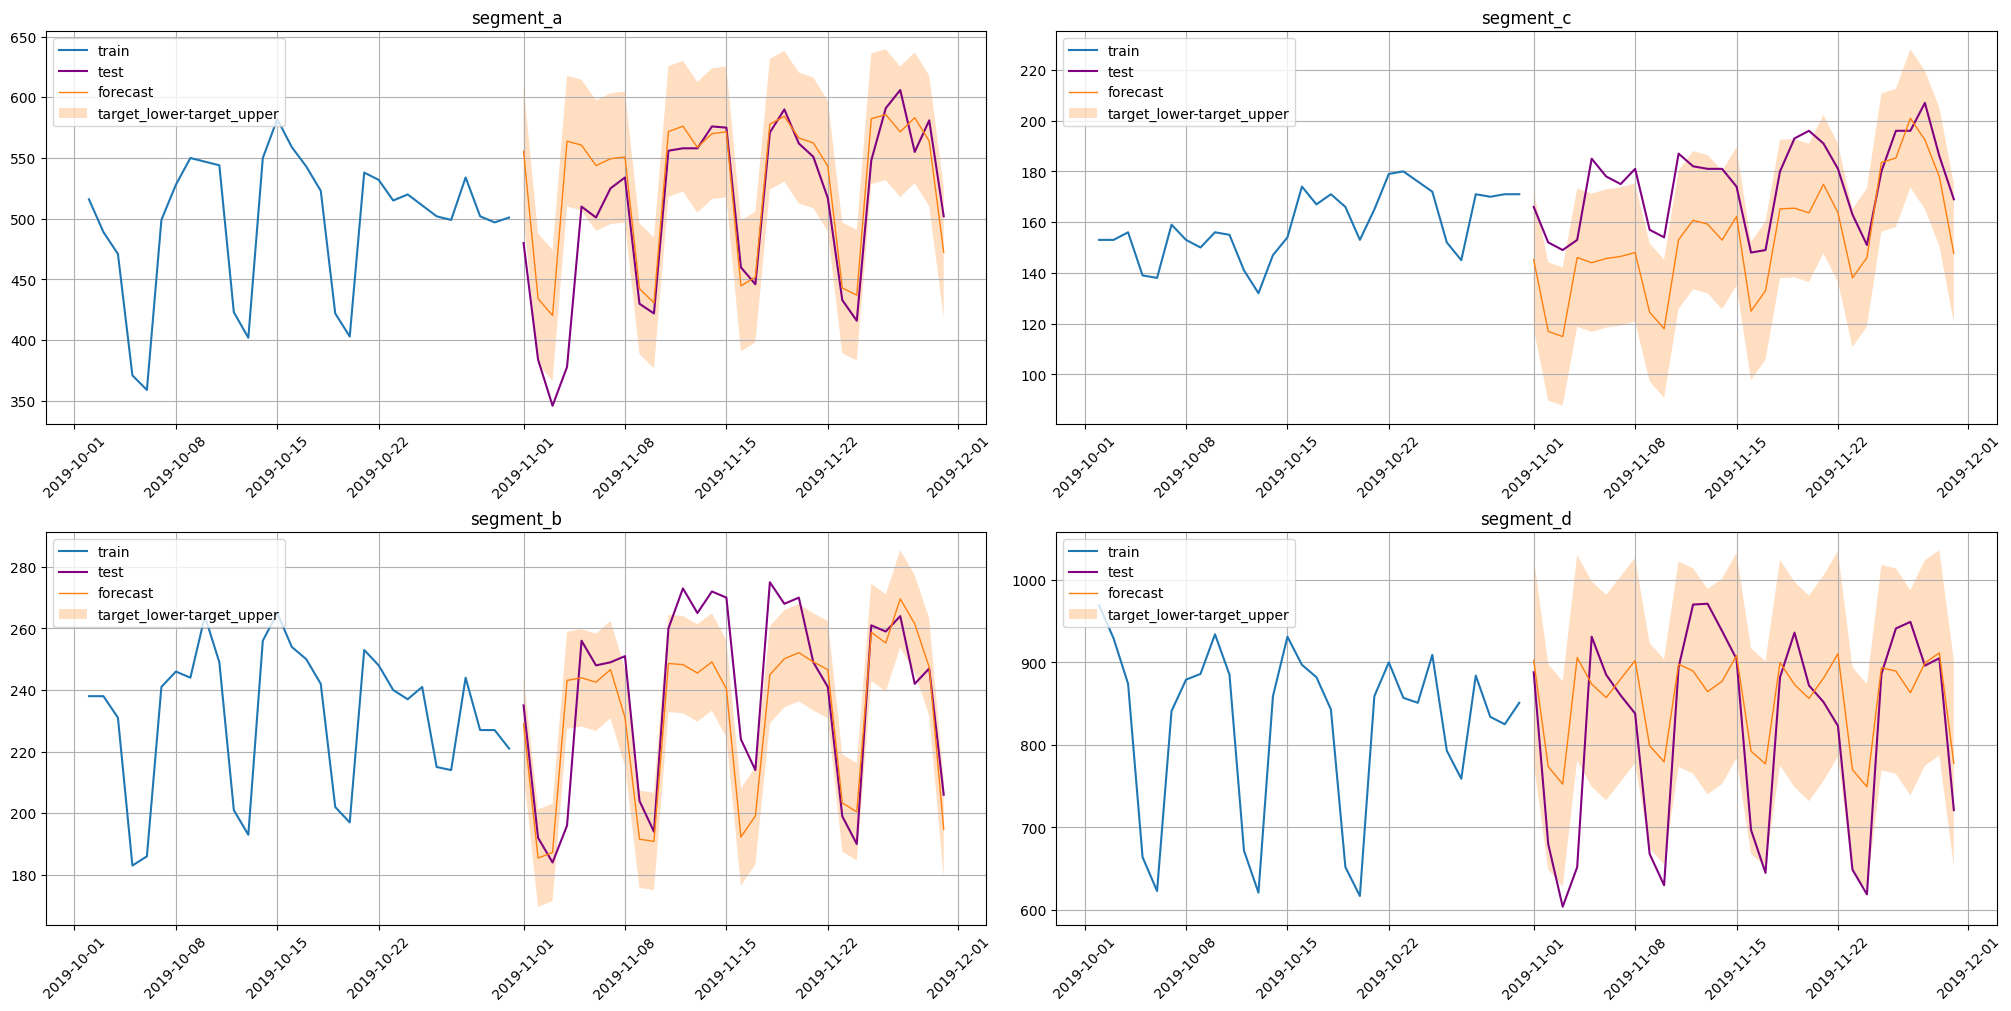

In [47]:
plot_forecast(forecast, test_ts, train_ts, prediction_intervals=True, n_train_samples=30)

In [48]:
coverage, width = interval_metrics(test_ts=test_ts, forecast=forecast)

In [49]:
coverage

{'segment_a': 0.9,
 'segment_b': 0.6333333333333333,
 'segment_c': 0.6,
 'segment_d': 0.8}

In [50]:
width

{'segment_a': 107.70609705250062,
 'segment_b': 31.586568499457332,
 'segment_c': 54.49407669650873,
 'segment_d': 248.7648953344571}

Obtaining historical residuals for prediction intervals estimation can be
simplified by using the more efficient utility function `residuals_matrices`.
This function accepts pipeline, data, parameters for backtest and computes residuals
for each segment on every fold.

**Note** that `residuals_matrices` function returns a 3 dimensional array with axes sizes `(num_folds, horizon, num_segments)`.

Here we use this function to optimize the proposed method. Consider `OptimizedMaxAbsResidInterval`.

In [51]:
from etna.experimental.prediction_intervals.utils import residuals_matrices


class OptimizedMaxAbsResidInterval(BasePredictionIntervals):
    def __init__(self, pipeline: BasePipeline, coverage: float = 0.95, stride: int = 1):
        assert stride > 0
        assert 0 < coverage <= 1

        self.stride = stride
        self.coverage = coverage
        super().__init__(pipeline=pipeline)

    def _forecast_prediction_interval(
        self, ts: TSDataset, predictions: TSDataset, quantiles: Sequence[float], n_folds: int
    ) -> TSDataset:
        residuals = residuals_matrices(pipeline=self, ts=ts, n_folds=n_folds, stride=self.stride)

        predicted_target = predictions[..., "target"]

        width = np.max(np.abs(residuals), axis=(0, 1)).reshape(1, -1)

        lower_border = predicted_target - self.coverage * width / 2
        upper_border = predicted_target + self.coverage * width / 2

        upper_border.rename({"target": "target_upper"}, inplace=True, axis=1)
        lower_border.rename({"target": "target_lower"}, inplace=True, axis=1)

        predictions.add_prediction_intervals(prediction_intervals_df=pd.concat([lower_border, upper_border], axis=1))
        return predictions

In [52]:
pipeline = OptimizedMaxAbsResidInterval(pipeline=pipeline)

forecast = pipeline.forecast(prediction_interval=True, n_folds=3)

forecast

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   15.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   15.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0

segment                                                                                                                                                                                                                                                                                                                                      segment_a  \
feature    DateFlagsTransform(day_number_in_week = False, day_number_in_month = False, day_number_in_year = False, week_number_in_month = False, week_number_in_year = False, month_number_in_year = False, season_number = False, year_number = False, is_weekend = True, special_days_in_week = (), special_days_in_month = (), out_column = None, )   
timestamp                                                                                                                                                                                                                                                                                                                                                
2019-11-01                                              False                                                                                                                                                                                                                                                                                            
2019-11-02                                               True                                                                                                                                                                                                                                                                                            
2019-11-03                                               True                                                                                                                                                                                                                                                                                            
2019-11-04                                              False                                                                                                                                                                                                                                                                                            
2019-11-05                                              False                                                                                                                                                                                                                                                                                            
2019-11-06                                              False                                                                                                                                                                                                                                                                                            
2019-11-07                                              False                                                                                                                                                                                                                                                                                            
2019-11-08                                              False                                                                                                                                                                                                                                                                                            
2019-11-09                                               True                                                                                                                                     

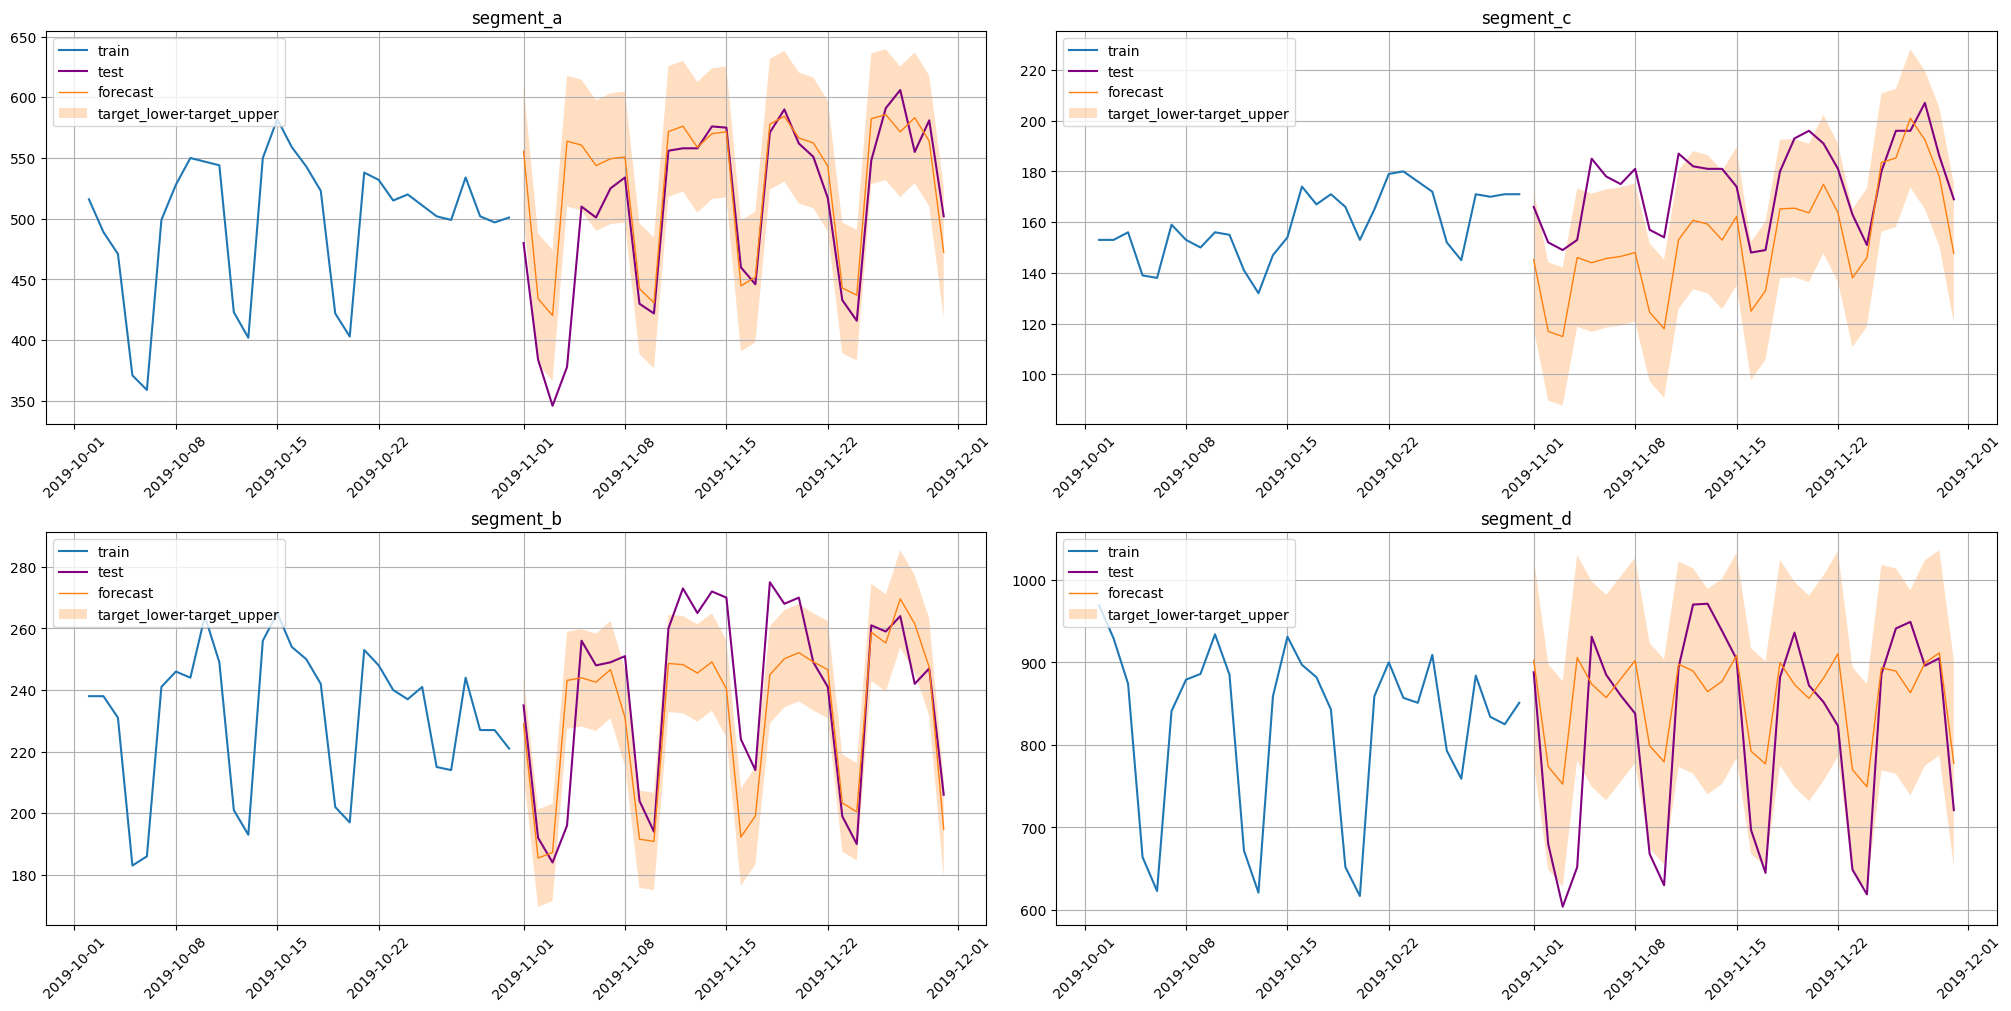

In [53]:
plot_forecast(forecast, test_ts, train_ts, prediction_intervals=True, n_train_samples=30)

In [54]:
coverage, width = interval_metrics(test_ts=test_ts, forecast=forecast)

In [55]:
coverage

{'segment_a': 0.9,
 'segment_b': 0.6333333333333333,
 'segment_c': 0.6,
 'segment_d': 0.8}

In [56]:
width

{'segment_a': 107.70609705250062,
 'segment_b': 31.586568499457332,
 'segment_c': 54.49407669650873,
 'segment_d': 248.7648953344571}